In [1]:
import ompy as om
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pymc3 as mc
import fbu
from matplotlib import rc
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

In [4]:
dpi = 120
rc('figure',dpi = dpi)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

rc('font', size=10)

rc('figure', figsize = (4,3))

rc('legend', fontsize = 10)
rc('axes', labelsize = 10)
rc('axes', titlesize = 10)
rc('xtick', labelsize = 10)
rc('ytick', labelsize = 10)


<IPython.core.display.Javascript object>


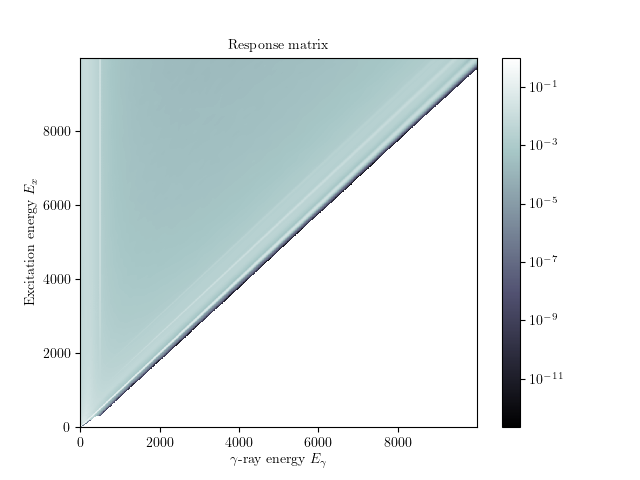

In [3]:
# Plot response matrix

%matplotlib notebook
%matplotlib notebook

# Synthetic true data before folding
raw_true = om.Matrix(path="Synthetic_data/threestates-cascades.m")
Eg_true = raw_true.Eg

# Response matrix from file
path = "ompy/OCL_response_functions/oscar2017_scale1.15"
response_object = om.Response(path)

fwhm_abs = 30
response, response_table = response_object.interpolate(Eg_true, fwhm_abs=fwhm_abs, return_table = True)

response.plot(title="Response matrix", scale='log', cmap=plt.get_cmap('bone'))
plt.savefig('figures/response_true.pdf',
            bbox_inches='tight')

<IPython.core.display.Javascript object>


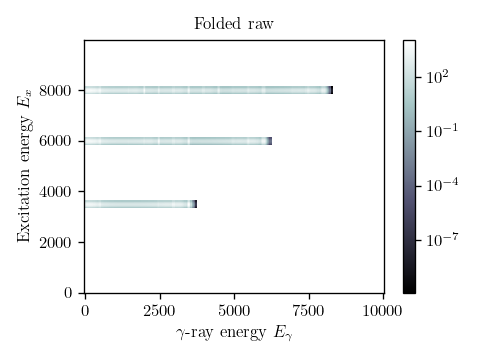

In [5]:
# Plot folded true data, mimicking detector output
%matplotlib notebook
%matplotlib notebook

# Fold raw with response
raw_true_folded = raw_true@response

Ex_true = raw_true_folded.Ex
gauss_fwhm = 100
# Apply a Gauss-smoothing to match the real detector resolution
raw_s = om.gauss_smoothing_matrix_1D(raw_true_folded, Ex_true, gauss_fwhm, axis = 'Ex')
raw_smooth = om.Matrix(values = raw_s, Ex = Ex_true, Eg = Eg_true)

# Reduce number of bins for better performance
raw_smooth_rebinned = raw_smooth.rebin(axis = 'Eg', factor = 4, inplace = False)
raw_true_rebinned = raw_true.rebin(axis = 'Eg', factor = 4, inplace = False)

# Plot the folded and smoothed raw spectrum

raw_smooth_rebinned.plot(cmap=plt.get_cmap('bone'))
plt.title('Folded raw')
plt.tight_layout()
plt.show()
plt.savefig('figures/folded_smoothed_raw.pdf',
            bbox_inches='tight')

<IPython.core.display.Javascript object>


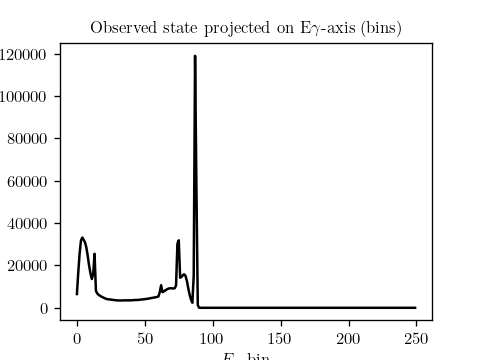

<IPython.core.display.Javascript object>


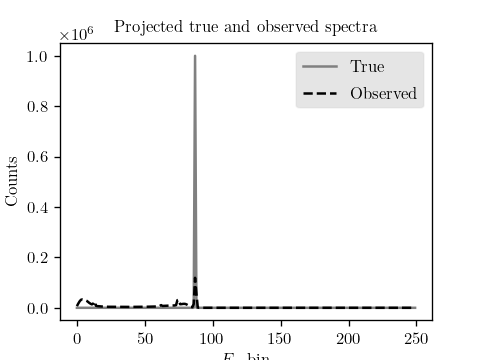

In [103]:
# Project spectra
%matplotlib notebook
%matplotlib notebook

Eg = raw_smooth_rebinned.Eg

# Define Ex-axis bounds for projection
# Excited state: First / Second / Third 
# Emin           3200  /  5600  / 7600  
# Emax           4000  /  6400  / 8400  
Emin = 3200 
Emax = 4000

# Emin = 5600 
# Emax = 6400 

# Emin = 7600 
# Emax = 8400  

# Project the true spectrum on the Eg axis
raw_true_projection, E_true = raw_true_rebinned.projection(axis = 'Eg', Emin = Emin, Emax = Emax)

# Project the observed spectrum
raw_projection, E = raw_smooth_rebinned.projection(axis='Eg', Emin=Emin, Emax=Emax)

# Plot the projected observed spectrum
plt.plot(raw_projection, color = 'black')
plt.title(r'Observed state projected on E$\gamma$-axis (bins)')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel("Counts")
plt.savefig('figures/observed_proj_Emax_{}.pdf'.format(Emax),
            bbox_inches='tight')

# Compare true with observed
plt.figure()
plt.plot(raw_true_projection, color = 'grey', label = 'True')
plt.plot(raw_projection, color = 'black', ls = '--', label = 'Observed')
plt.title(r'Projected true and observed spectra')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel("Counts")
plt.legend(facecolor='grey', framealpha=0.2)
plt.savefig('figures/observed_true_proj_Emax_{}.pdf'.format(Emax),
            bbox_inches='tight')

plt.show()

<IPython.core.display.Javascript object>


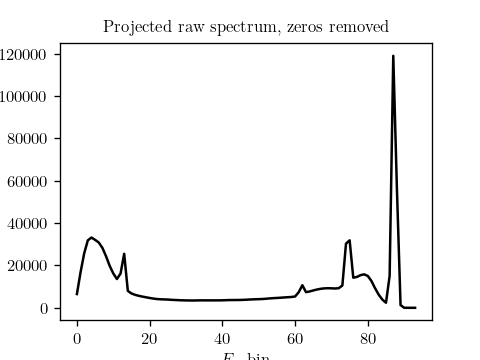

Text(0, 0.5, 'Counts')

In [56]:
%matplotlib notebook
%matplotlib notebook

# Remove zeros from the raw spectrum, necessary to run PyFBU

# Determine indices of zeros in the array, there should be no nonzero counts after the first bin containing zero
# Returns a tuple where the first element is an array of indices
zero_indices = np.where(raw_projection == 0)

# Remove all trailing zeros
raw_no_zeros = raw_projection[:zero_indices[0][0]]
energy = Eg[:zero_indices[0][0]]

# Do the same for raw true, for later comparison
raw_true_no_zeros = raw_true_projection[:zero_indices[0][0]]

plt.plot(raw_no_zeros, color = 'black')
plt.title("Projected raw spectrum, zeros removed")
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')

-1.4732035079515182e-14


<IPython.core.display.Javascript object>


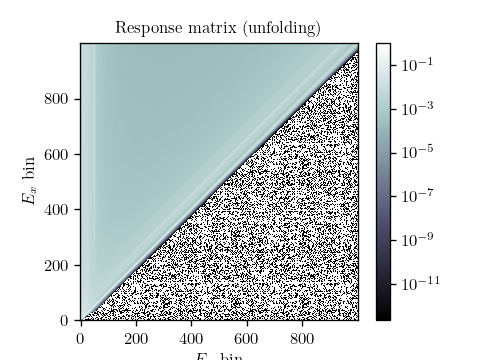

In [101]:
%matplotlib notebook
%matplotlib notebook

# Normalizing the rows of the response
sum_of_rows = response.values.sum(axis=1)
normalized_array = response.values / sum_of_rows[:, np.newaxis]
resp = normalized_array

plt.figure()
plt.imshow(resp,origin = 'lower',norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('bone'))

plt.colorbar()
plt.title("Response matrix (unfolding)")

plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel(r'$E_{x}$ bin')
plt.show()

plt.savefig('figures/response_unfolding.pdf',
            bbox_inches='tight')


<IPython.core.display.Javascript object>


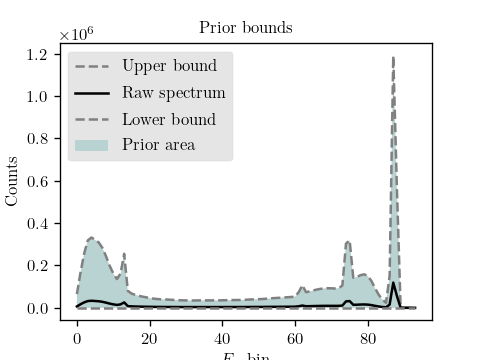

In [58]:
# Priors
%matplotlib notebook
%matplotlib notebook

# Defining lower and upper prior bounds
lower = np.zeros(len(raw_no_zeros))
upper = raw_no_zeros*10


# Plot a shaded prior area
plt.fill_between(x = range(len(energy)), y1 = lower, y2 = upper, facecolor=plt.get_cmap('bone')(0.8), label =r'Prior area')

# Plot lower and upper prior with raw
plt.plot(range(len(energy)), upper,ls='dashed', label = 'Upper bound', color = 'grey')
plt.plot(range(len(energy)), raw_no_zeros, ls='-', label= 'Raw spectrum', color = 'black')
plt.plot(range(len(energy)), lower, ls='dashed', label = 'Lower bound', color = 'grey')


plt.title('Prior bounds')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.show()
plt.savefig('figures/priors.pdf',
            bbox_inches='tight')

In [38]:
# Create PyFBU object
myfbu = fbu.PyFBU()

# Set the response
myfbu.response = resp

# Set data and priors 
myfbu.data = raw_no_zeros
myfbu.prior = 'Uniform'
myfbu.upper = upper   
myfbu.lower = lower

# Set the number of tuning and sampling steps
myfbu.nTune = 1000
myfbu.nMCMC = 5000

# Run PyFBU
myfbu.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


None


Sequential sampling (2 chains in 1 job)
NUTS: [truth93, truth92, truth91, truth90, truth89, truth88, truth87, truth86, truth85, truth84, truth83, truth82, truth81, truth80, truth79, truth78, truth77, truth76, truth75, truth74, truth73, truth72, truth71, truth70, truth69, truth68, truth67, truth66, truth65, truth64, truth63, truth62, truth61, truth60, truth59, truth58, truth57, truth56, truth55, truth54, truth53, truth52, truth51, truth50, truth49, truth48, truth47, truth46, truth45, truth44, truth43, truth42, truth41, truth40, truth39, truth38, truth37, truth36, truth35, truth34, truth33, truth32, truth31, truth30, truth29, truth28, truth27, truth26, truth25, truth24, truth23, truth22, truth21, truth20, truth19, truth18, truth17, truth16, truth15, truth14, truth13, truth12, truth11, truth10, truth9, truth8, truth7, truth6, truth5, truth4, truth3, truth2, truth1, truth0]
100%|██████████| 6000/6000 [01:09<00:00, 86.27it/s]


Elapsed 0:02:55 (68.24 samples/second)
[ 11.30630724  65.08092013 113.7947463  ...   4.81845857  34.59430493
 195.07520316]


(array([-4427.37053757, -4418.10617134, -4416.55354862, ...,
        -4429.00567152, -4414.30181508, -4421.59386169]),
 <MultiTrace: 2 chains, 5000 iterations, 188 variables>)

In [39]:
# Get all posterior samples for each bin, a list of lists
trace = myfbu.trace
print(len(trace), len(trace[0]))

94 10000


In [40]:
# Calculate means, medians and standard deviations for each posterior
means = np.mean(trace, axis = 1)
medians = np.median(trace, axis = 1)
sigmas = np.std(trace, axis = 1)


In [41]:
# Calculating the HPD interval using PyMC3, and its mean
hpd = mc.stats.hpd(np.array(trace).T, alpha = 1-0.68)   
hpd_mean = np.mean(hpd, axis = 1)


In [42]:
# Calculating the MAP
myfbu.mode = True
myfbu.run()

None


logp = -4,857, ||grad|| = 0.24472: 100%|██████████| 128/128 [00:00<00:00, 559.81it/s]  


{'truth0_interval__': array(-129.83892062), 'truth1_interval__': array(-112.60364136), 'truth2_interval__': array(-121.01924015), 'truth3_interval__': array(-132.58955089), 'truth4_interval__': array(-135.64325513), 'truth5_interval__': array(-132.41480731), 'truth6_interval__': array(-128.93670574), 'truth7_interval__': array(-123.73465986), 'truth8_interval__': array(-117.20806154), 'truth9_interval__': array(-105.38815232), 'truth10_interval__': array(-104.39075128), 'truth11_interval__': array(-113.05963559), 'truth12_interval__': array(-113.31316449), 'truth13_interval__': array(-107.42214197), 'truth14_interval__': array(-114.95467692), 'truth15_interval__': array(-116.24936254), 'truth16_interval__': array(-115.05101827), 'truth17_interval__': array(-114.15034649), 'truth18_interval__': array(-112.98033352), 'truth19_interval__': array(-112.63155141), 'truth20_interval__': array(-112.17189416), 'truth21_interval__': array(-111.70192991), 'truth22_interval__': array(-111.88192156

In [43]:
# Convert MAP dict to numpy array
MAP = np.fromiter(myfbu.MAP.values(), dtype=float)
# The second half of the original MAP contains the values we want
MAP = MAP[int(len(MAP)/2):]
print(len(MAP))

94


<IPython.core.display.Javascript object>


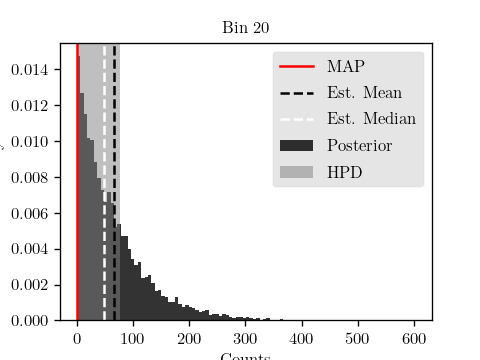

<IPython.core.display.Javascript object>


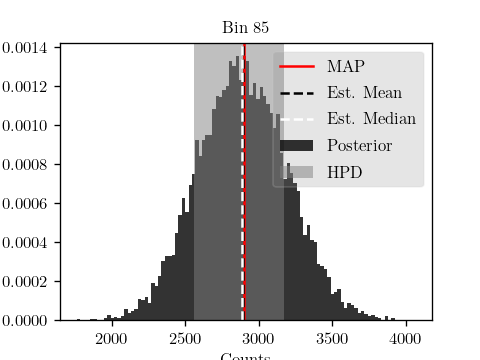

<IPython.core.display.Javascript object>


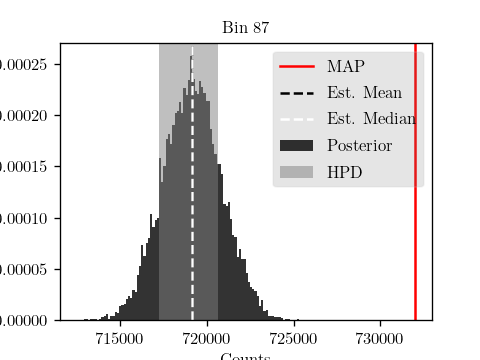

In [73]:
%matplotlib notebook
%matplotlib notebook

# Take a look at the situation for 3 bins
bin_numbers = [20, 85, 87]

for i in range(len(bin_numbers)):
    plt.figure()
    # Plot a histogram of the posterior
    plt.hist(trace[bin_numbers[i]], label = 'Posterior',
                        bins = 100, density = True, color = 'black', alpha = 0.8)

    # Plot lines at the positions of the mean, median and MAP estimates
    plt.axvline(x=MAP[bin_numbers[i]], color = 'red', ls = '-', label = 'MAP')
    plt.axvline(x=means[bin_numbers[i]], color = 'black', alpha = 1, ls = '--', label = 'Est. Mean')
    plt.axvline(x=medians[bin_numbers[i]], color = 'white', ls = '--', label = 'Est. Median')
    
    # Plot the HPD interval as a shaded area
    plt.axvspan(hpd[bin_numbers[i]][0], hpd[bin_numbers[i]][1], facecolor='grey', alpha=0.5, label=r'HPD')

    plt.title('Bin {}'.format(bin_numbers[i]))
    plt.xlabel('Counts')
    plt.ylabel('Probability')
    plt.legend(facecolor='grey', framealpha=0.2)
    plt.show()
    plt.savefig('figures/posterior_{}.pdf'.format(bin_numbers[i]),
            bbox_inches='tight')

<IPython.core.display.Javascript object>


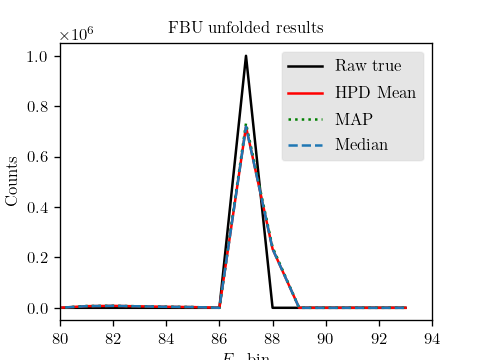

Mean absolute errors:
---------------------
HPD Mean: 5953.485218379783
Median: 5960.368752189168
MAP: 5701.630456095564

R2-score:
---------------------
HPD Mean: 0.8646918040767955
Median: 0.8647963058709892
MAP: 0.8689015169749487


In [90]:
%matplotlib notebook
%matplotlib notebook

# Display entire spectrum using the estimates for each bin

plt.plot(range(len(energy)), raw_true_no_zeros, color='black', ls='-', label = r'Raw true')
plt.plot(range(len(energy)), hpd_mean, color='red', ls='-', label = r'HPD Mean')

plt.plot(range(len(energy)), MAP, color = 'green', ls=':', label = 'MAP')
plt.plot(range(len(energy)), medians, ls='--', label = 'Median')

plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend()
plt.xlim(80, 94)
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('FBU unfolded results')

print('Mean absolute errors:')
print('---------------------')
print('HPD Mean:', np.mean(np.abs(raw_true_no_zeros - hpd_mean)))
print('Median:', np.mean(np.abs(raw_true_no_zeros - medians)))
print('MAP:', np.mean(np.abs(raw_true_no_zeros - MAP))) 

print('\nR2-scores:')
print('---------------------')
print('HPD Mean:', 1 - (np.sum((raw_true_no_zeros - hpd_mean)**2))/(np.sum((raw_true_no_zeros - np.mean(raw_true_no_zeros))**2)))
print('Median:', 1 - (np.sum((raw_true_no_zeros - medians)**2))/(np.sum((raw_true_no_zeros - np.mean(raw_true_no_zeros))**2)))
print('MAP:', 1 - (np.sum((raw_true_no_zeros - MAP)**2))/(np.sum((raw_true_no_zeros - np.mean(raw_true_no_zeros))**2)))  

plt.show()
plt.savefig('figures/entire_unfolded.pdf',
            bbox_inches='tight')

<IPython.core.display.Javascript object>


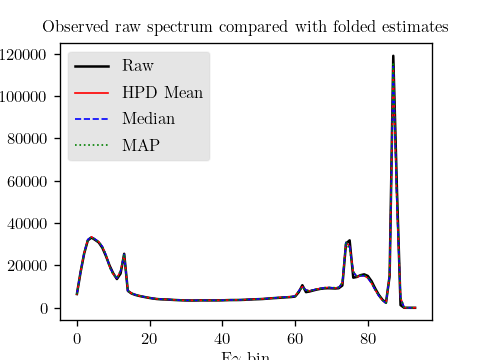

Mean absolute errors:
---------------------
HPD Mean: 432.83189345421215
Median: 439.97892023883776
MAP: 407.86654423352087

R2-scores:
---------------------
HPD Mean: 0.9942829530317967
Median: 0.994290879454388
MAP: 0.9951786200029042


In [91]:
%matplotlib notebook
%matplotlib notebook
# Compare the folded estimates with the raw spectrum
plt.plot( raw_no_zeros, label='Raw', color = 'black')
plt.plot( hpd_mean@resp, color = 'red', ls='-', linewidth = 1, label = r'HPD Mean')
plt.plot( medians@resp, ls='--', color = 'blue', linewidth = 1, label = 'Median')
plt.plot( MAP@resp, ls='dotted', color = 'green', linewidth = 1, label = 'MAP')

# plt.yscale('log')
plt.title('Observed raw spectrum compared with folded estimates')
plt.ylabel('Counts')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.show()

print('Mean absolute errors:')
print('---------------------')
print('HPD Mean:', np.mean(np.abs(raw_no_zeros - hpd_mean@resp)))
print('Median:', np.mean(np.abs(raw_no_zeros - medians@resp)))
print('MAP:', np.mean(np.abs(raw_no_zeros - MAP@resp)))

print('\nR2-scores:')
print('---------------------')
print('HPD Mean:', 1 - (np.sum((raw_no_zeros - hpd_mean@resp)**2))/(np.sum((raw_no_zeros - np.mean(raw_no_zeros))**2)))
print('Median:', 1 - (np.sum((raw_no_zeros - medians@resp)**2))/(np.sum((raw_no_zeros - np.mean(raw_no_zeros))**2)))
print('MAP:', 1 - (np.sum((raw_no_zeros - MAP@resp)**2))/(np.sum((raw_no_zeros - np.mean(raw_no_zeros))**2)))  

plt.savefig('figures/entire_folded.pdf',
            bbox_inches='tight')

<IPython.core.display.Javascript object>


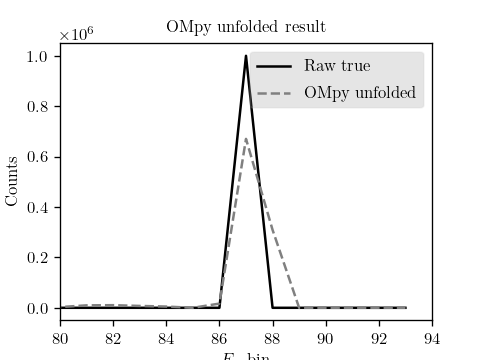

<IPython.core.display.Javascript object>


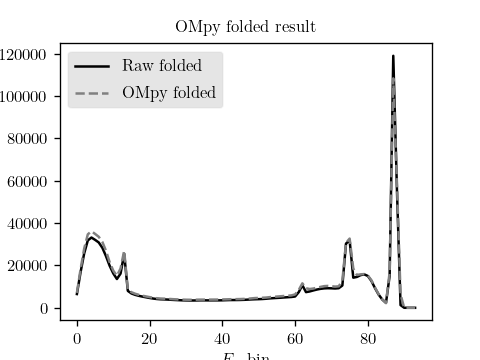

Mean absolute errors:
---------------------
Unfolded: 7787.27057021666
Folded: 1002.6507259802444

R2-scores:
---------------------
Unfolded: 0.7924087060849985
Folded: 0.9868054163944187


In [92]:
# Folding iteration method
%matplotlib notebook
%matplotlib notebook

response_ompy, table = response_object.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
# The ompy unfolder requires a mock matrix if unfolding a 1D spectrum
ompy_raw = om.Matrix(np.array([raw_projection, raw_projection]), Eg = Eg)
ompy_unfolder = om.Unfolder(response=response_ompy)
# Required for compton subtraction
ompy_unfolder.response_tab = table 

# The output is a tuple of 2 identical unfolded spectra, get the first
ompy_unfolded = ompy_unfolder(ompy_raw)[0]
ompy_folded = ompy_unfolded@response_ompy.values

# Slice the array to match the sizes used by FBU
unfolded_shortened = ompy_unfolded[:zero_indices[0][0]]
folded_shortened = ompy_folded[:zero_indices[0][0]]

plt.plot(raw_true_no_zeros, color = 'black', label = 'Raw true')
plt.plot(unfolded_shortened, color = 'grey', ls = '--', label = 'OMpy unfolded')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy unfolded result')
plt.xlim(80, 94)
plt.savefig('figures/ompy_unfolded.pdf',
            bbox_inches='tight')

plt.figure()
plt.plot(raw_no_zeros, color = 'black', label = 'Raw folded')
plt.plot(folded_shortened, color = 'grey', ls = '--', label = 'OMpy folded')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy folded result')

plt.savefig('figures/ompy_folded.pdf',
            bbox_inches='tight')

plt.show()
print('Mean absolute errors:')
print('---------------------')
print('Unfolded:', np.mean(np.abs(raw_true_no_zeros - unfolded_shortened)))
print('Folded:', np.mean(np.abs(raw_no_zeros - folded_shortened)))

print('\nR2-scores:')
print('---------------------')
print('Unfolded:', 1 - (np.sum((raw_true_no_zeros - unfolded_shortened)**2))/(np.sum((raw_true_no_zeros - np.mean(raw_true_no_zeros))**2)))
print('Folded:', 1 - (np.sum((raw_no_zeros - folded_shortened)**2))/(np.sum((raw_no_zeros - np.mean(raw_no_zeros))**2)))
